In [1]:
import sys
import os
scratch_dir = "/home/hice1/eresmini3/scratch"
sys.path.append(f"{scratch_dir}/cold_diffusion_roi")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib

from torch.utils.data import DataLoader

from utils.mri_data import SliceDataset
from utils.data_transform import DataTransform_Diffusion
from utils.sample_mask import RandomMaskGaussianDiffusion, RandomMaskDiffusion, RandomMaskDiffusion2D
from utils.misc import *
from help_func import print_var_detail

from utils.visualize_utils import Visualizer_Kspace_ColdDiffusion
import utils.testing_utils as tu

from diffusion.kspace_diffusion import KspaceDiffusion
from utils.diffusion_train import Trainer
from net.u_net_diffusion import Unet

print(torch.__version__)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device:', device)

2.6.0+cu126
device: cuda:0


/home/hice1/eresmini3/scratch/cold_diffusion_roi/utils/testing_utils.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
# ****** TRAINING SETTINGS ******
# dataset settings
acc = 4  # acceleration factor
frac_c = 0.08  # center fraction
path_dir_train = f"{scratch_dir}/data/singlecoil_train"
path_dir_test = f"{scratch_dir}/data/singlecoil_test"
img_mode = 'fastmri'
bhsz = 6
img_size = 320

In [4]:
# ====== Construct dataset ======
# initialize mask
mask_func = RandomMaskGaussianDiffusion(
    acceleration=acc,
    center_fraction=frac_c,
    size=(1, img_size, img_size),
)

# initialize dataset
data_transform = DataTransform_Diffusion(
    mask_func,
    img_size=img_size,
    combine_coil=True,
    flag_singlecoil=True,
)

# training set
dataset_train = SliceDataset(
    root=pathlib.Path(path_dir_train),
    transform=data_transform,
    sample_rate=0.1,
    challenge='singlecoil',
    num_skip_slice=5,
)

# test set
dataset_test = SliceDataset(
    root=pathlib.Path(path_dir_test),
    transform=data_transform,
    sample_rate=0.1,
    challenge='singlecoil',
    num_skip_slice=5,
)

dataloader_train = DataLoader(dataset_train, batch_size=bhsz, shuffle=True, worker_init_fn=lambda worker_id: np.random.seed(42))
dataloader_test = DataLoader(dataset_test, batch_size=bhsz, shuffle=True, worker_init_fn=lambda worker_id: np.random.seed(42))
print('len dataloader train:', len(dataloader_train))
print('len dataloader test:', len(dataloader_test))

len dataloader train: 433
len dataloader test: 49


In [5]:
# model settings
CH_MID = 64
# training settings
NUM_EPOCH = 50
learning_rate = 2e-5
time_steps = 1000
train_steps = NUM_EPOCH * len(dataloader_train) # can be customized to a fixed number, however, it should reflect the dataset size.
train_steps = max(train_steps, 35000)
print('train_steps:',train_steps)

train_steps: 35000


In [6]:
absolute_path = f"{scratch_dir}/cold_diffusion_roi"
PATH_MODEL = f'{absolute_path}/saved_models/fastmri_knee/tuned_2_ROI_diffusion_fastmri_8x_T1000_S35000/'

In [7]:
# construct diffusion model
save_folder=PATH_MODEL
load_path=f"{PATH_MODEL}model_25000.pt"
blur_routine='Constant'
train_routine='Final'
sampling_routine='x0_step_down'
discrete=False

model = Unet(
    dim=CH_MID,
    dim_mults=(1, 2, 4, 8),
    channels=2,
).cuda()
print('model size: %.3f MB' % (calc_model_size(model)))

diffusion = KspaceDiffusion(
    model,
    image_size=img_size,
    device_of_kernel='cuda',
    channels=2,
    timesteps=time_steps,  # number of steps
    loss_type='l1',  # L1 or L2
    blur_routine=blur_routine,
    train_routine=train_routine,
    sampling_routine=sampling_routine,
    discrete=discrete,

    # sobel_threshold=0.3,
    # dilation_size=9,
).cuda()

Is Time embed used ?  True
model size: 53.992 MB


In [8]:
# construct trainer and train

trainer = Trainer(
    diffusion,
    image_size=img_size,
    train_batch_size=bhsz,
    train_lr=learning_rate,
    train_num_steps=train_steps,  # total training steps
    gradient_accumulate_every=2,  # gradient accumulation steps
    ema_decay=0.995,  # exponential moving average decay
    fp16=False,  # turn on mixed precision training with apex
    save_and_sample_every=200,
    results_folder=save_folder,
    load_path=load_path,
    dataloader_train=dataloader_train,
    dataloader_test=dataloader_test,
)
#trainer.test(t=125)
sample_imgs, gt_imgs, xt, direct_recons = trainer.recon_slice(t=125, idx_case=1)

Loading :  /home/hice1/eresmini3/scratch/cold_diffusion_roi/saved_models/fastmri_knee/tuned_2_ROI_diffusion_fastmri_8x_T1000_S35000/model_25000.pt



Evaluation:


/home/hice1/eresmini3/scratch/conda_venvs/finalEnv/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `peak_signal_noise_ratio` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `peak_signal_noise_ratio` from `torchmetrics.image` instead.
  _future_warning(
/home/hice1/eresmini3/scratch/conda_venvs/finalEnv/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


### NMSE: tensor(0.0009, device='cuda:0')|| PSNR: tensor(40.9441, device='cuda:0')|| SSIM: tensor(0.9733, device='cuda:0')
----------------------------------------------------------------------


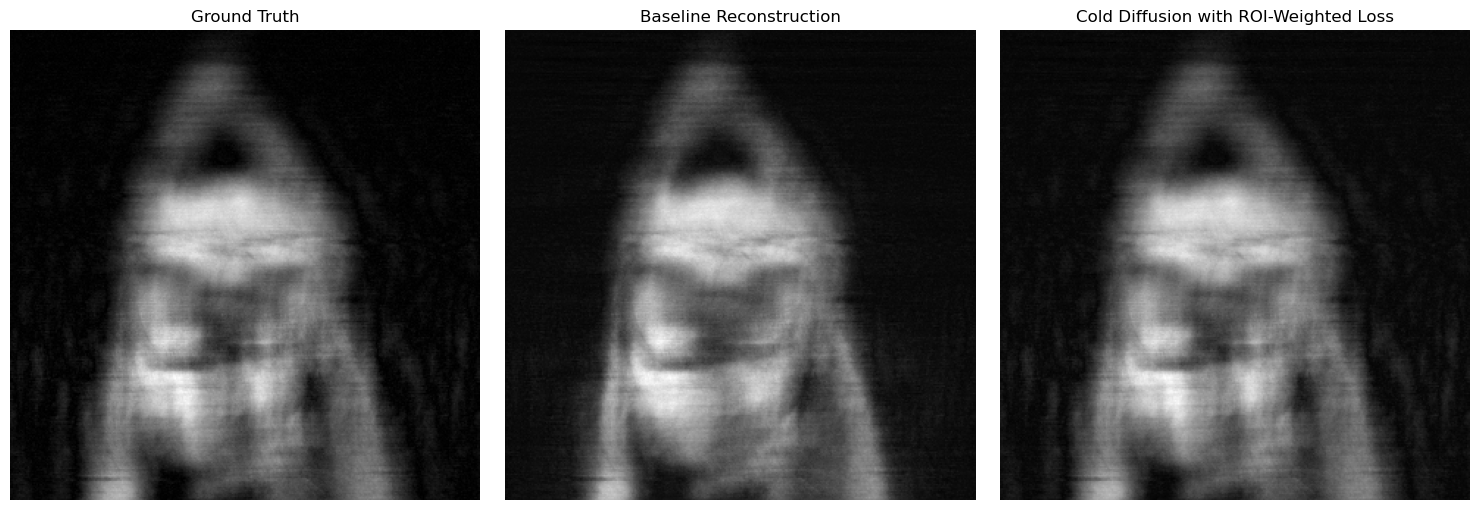

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
slice = 4
 
axs[0].imshow(gt_imgs[slice, 0 , :, :, 0].cpu(), cmap="gray")
axs[0].set_title("Ground Truth")

axs[1].imshow(direct_recons[slice, 0 , :, :, 0].cpu(), cmap="gray")
axs[1].set_title("Baseline Reconstruction")

axs[2].imshow(sample_imgs[slice, 0, :, :, 0].cpu(), cmap="gray")
axs[2].set_title(f"Cold Diffusion with ROI-Weighted Loss")

for ax in axs:
    ax.axis("off")
 
plt.tight_layout()
plt.show()

In [10]:
visualizer = Visualizer_Kspace_ColdDiffusion(
        diffusion,
        dataloader_test=dataloader_test,
        load_path=load_path,
    )
results = visualizer.show_intermediate_kspace_cold_diffusion(t=125, idx_case=1)

Loading :  /home/hice1/eresmini3/scratch/cold_diffusion_roi/saved_models/fastmri_knee/tuned_2_ROI_diffusion_fastmri_8x_T1000_S35000/model_25000.pt


In [11]:
 res = tu.recon_kspace_cold_diffusion(
        dataloader_test,
        diffusion,
        timesteps=125,
        device=device,
        idx_case=1,
        show_info=True)

AssertionError: Input net must be a KspaceDiffusion.

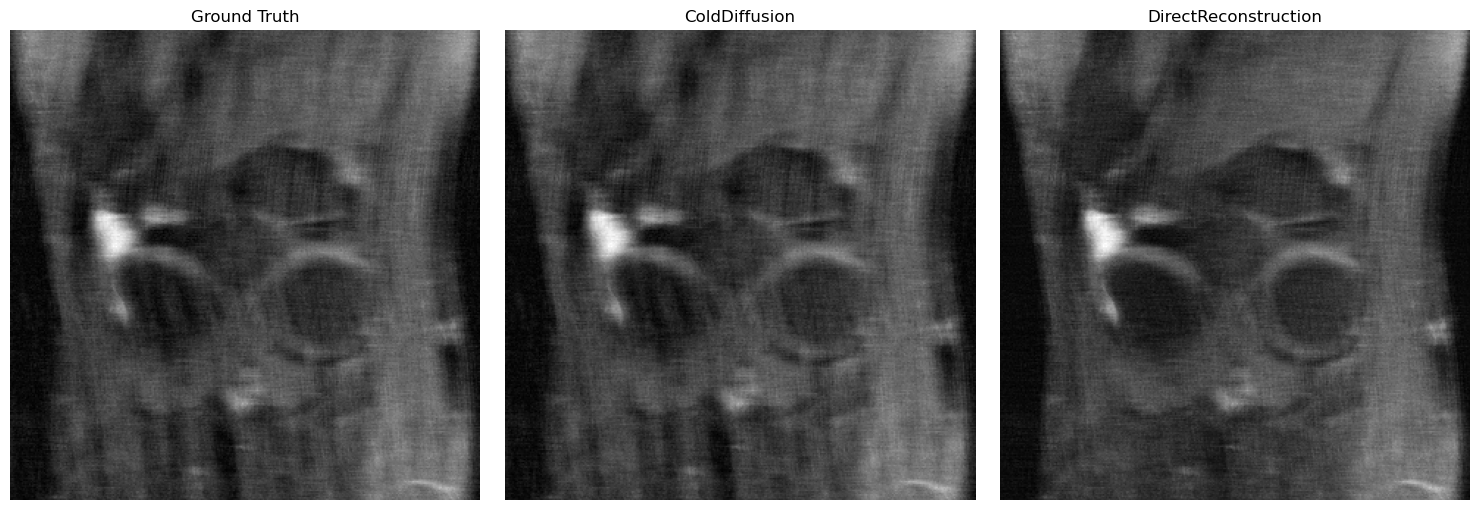

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(res[1][4, :, :], cmap="gray")
axs[0].set_title(f"Ground Truth")

axs[1].imshow(res[0][4, :, :], cmap="gray")
axs[1].set_title("ColdDiffusion")
#overlay_roi_box(axs[1], roi_size=roi_model.roi_size, img_shape=sample["baseline"].shape)

axs[2].imshow(res[2][4, :, :], cmap="gray")
axs[2].set_title("DirectReconstruction")
#overlay_roi_box(axs[2], roi_size=roi_model.roi_size, img_shape=sample["roi"].shape)

for ax in axs:
    ax.axis("off")

plt.tight_layout()
plt.show()

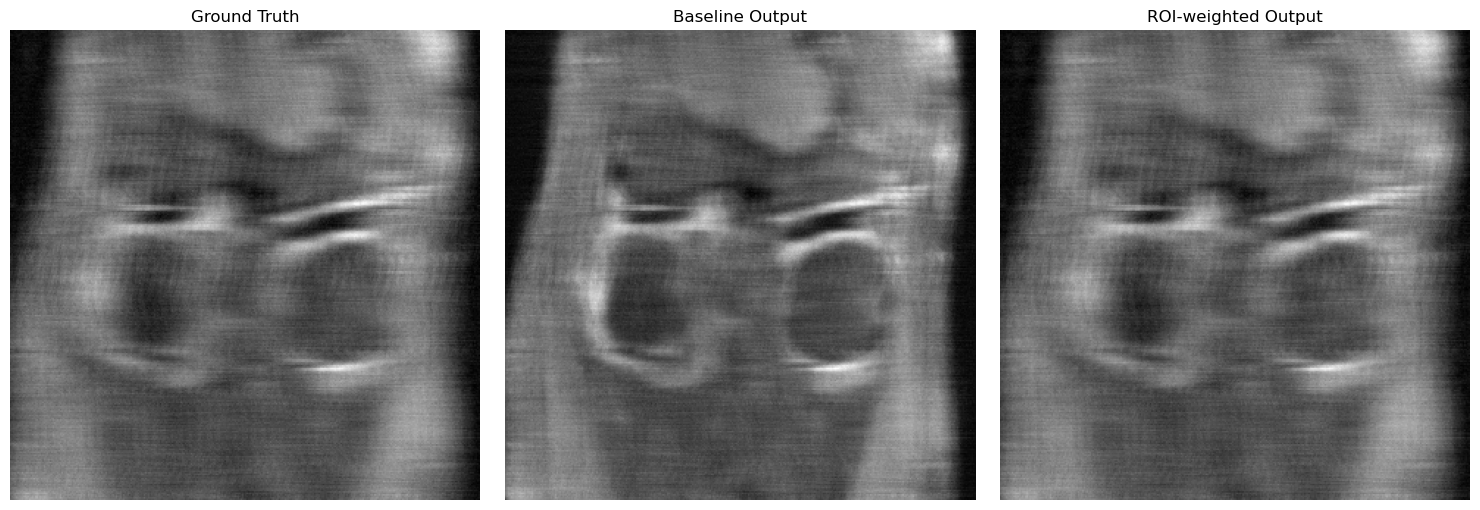

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(results[2].cpu(), cmap="gray")
axs[0].set_title(f"Ground Truth") #\n{sample['fname']} Slice {sample['slice']}")

axs[1].imshow(results[3].cpu(), cmap="gray")
axs[1].set_title("Baseline Output")
#overlay_roi_box(axs[1], roi_size=roi_model.roi_size, img_shape=sample["baseline"].shape)

axs[2].imshow(results[4].cpu(), cmap="gray")
axs[2].set_title("ROI-weighted Output")
#overlay_roi_box(axs[2], roi_size=roi_model.roi_size, img_shape=sample["roi"].shape)

for ax in axs:
    ax.axis("off")

plt.tight_layout()
plt.show()